# Rebuttal All Figures

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import itertools
import pickle
import os
import dill
from collections import defaultdict
import shap
from shap import TreeExplainer, LinearExplainer
from coai import knapsack, base, plots
from explainers import OneDimExplainer
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import interpolate
import config
from brokenaxes import brokenaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from localutils import rocplot

In [ ]:
from tqdm import tqdm

In [2]:
from load_ed import load_ed
from load_eicu import load_eicu
from load_outpatient import load_outpatient

CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)


In [3]:
SAVE_PLOTS = False
SAVE_PATH = 'figures_rebuttal'

In [4]:
RUNDIR = config.RUN_PATH

In [5]:
rmax = np.maximum.accumulate

# Load Data

In [6]:
LOADERS = {'trauma': lambda: load_ed(name=config.ED_NAME,costtype=config.ED_COSTTYPE,drop_redundant=True), 
           'icu': load_eicu, 'outpatient': load_outpatient}

ed_renamer = {'age':'Age','scenefirstpulse':'Pulse','intub':"Intubation",'race':"Race",'sex':"Sex",
           'scenefirstbloodpressure': 'Blood Pressure', 'scenelowestbloodpressure': "Lowest BP", 
           'scenefirstrespirationrate': 'Resp Rate', 'cpr': 'CPR','ethnicity':"Ethnicity",'scenegcs':'GCS',
          'scenehighestgcs': 'Highest GCS','causecode':"Cause of Injury",'dispatch':"Dispatch+Procedures",
          'scenegcseye': 'Eye GCS', 'scenegcsverbal': 'Verbal GCS', 'scenegcsmotor': 'Motor GCS'}# Interpretation matrix


In [7]:
icu_newcols = np.array(['Intub @ Worst ABG','Vent @ Worst RR','Dialysis','GCS Eyes','GCS Motor','GCS Verbal','Unscorable - Meds',
           'Urine','White Blood Cells','Temperature','Resp Rate','Sodium','Heart Rate',
           'Mean BP','pH','Hematocrit','Creatinine','Albumin','PaO2','PCO2','BUN','Glucose',
           'Bilirubin','fiO2',
           'Gender','Bed Count','Admit Source',' Graft Count','Age',
          'Admit Diagnosis', 'Vent @ Worst RR','Any Vent','Any Intub','Diabetes',
           'Ejection Fraction','Visit Number','MI Location','Unscorable - Meds','GCS Verbal',
          'GCS Motor','GCS Eyes','PaO2','FiO2'])
(Xtrain,ytrain), (Xvalid,yvalid), (Xtest,ytest), costs, groups, extras = LOADERS['icu']()
icu_renamer = {k:v for k,v in zip(Xtrain.columns,icu_newcols)}


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
def get_twin(ax):
    for other_ax in ax.figure.axes:
        if other_ax is ax:
            continue
        if other_ax.bbox.bounds == ax.bbox.bounds:
            return other_ax
    return None

In [9]:
def meancostperf(results,k=100):
    final_results = []
    costs = results[:,:,0]#([m.model_costs for m in models])
    scores = results[:,:,1]#([m.model_scores for m in models])
#         costs = np.array([[0]+[t[1] for t in m] for m in models])
#         scores = np.array([[0.5]+[t[0] for t in m] for m in models])
    xr = np.linspace(np.nanmin(costs), np.nanmax(costs),k)
    interpolations = []
    for c,s in zip(costs,scores):
        interpolations.append(interpolate.interp1d(c,s,kind='previous',bounds_error=False,fill_value=(np.nan,np.max(s)))(xr))
    return (xr,np.array(interpolations))

In [10]:
cdict = {'lightblue':'#56B4E9','pink':'#CC79A7','green':'#009E73','orange':'#D55E00',
        'darkblue':'#0072b2'}

In [11]:
colors = {k:v for k,v in zip(['trauma-coai','trauma-fixedmodel','trauma-imputemodel','trauma-cegb','trauma-nn','trauma-cwcf','trauma-linear'],['blue','cyan','navy','red','cornflowerblue','green','teal'])}
fancynames = {k:v for k,v in zip(['trauma-coai','trauma-fixedmodel','trauma-imputemodel','trauma-cegb','trauma-nn','trauma-cwcf','trauma-linear'],['CoAI (Retrain)','CoAI (Mean-Impute)','CoAI (MICE-Impute)','CEGB','CoAI (Retrain, MLP)','CWCF (Small $N$)','CoAI (Linear)'])}

In [12]:
def rocplot(truth,preds, title="",label="", ax=None, annotate=True, jitter=0.0, **kwargs):
    if ax is None: ax=plt.gca()
    f,t,th = roc_curve(truth,preds)
    ax.plot(f,t+jitter,label='%s'%(label),**kwargs)
    if annotate:
        ax.set_title(title)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
    return

# Summarize Datasets

In [957]:
coai_trauma = base.load_model('rebuttal_runs/trauma-gbmsage-5-None.coai')
coai_icu = base.load_model('rebuttal_runs/icu-gbmsage-3-None.coai')
coai_outpatient = base.load_model('rebuttal_runs/outpatient-gbmsage-39-None.coai')

In [1033]:
f"{SAVE_PATH}/summary.pdf"

'figures_rebuttal/summary.pdf'


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


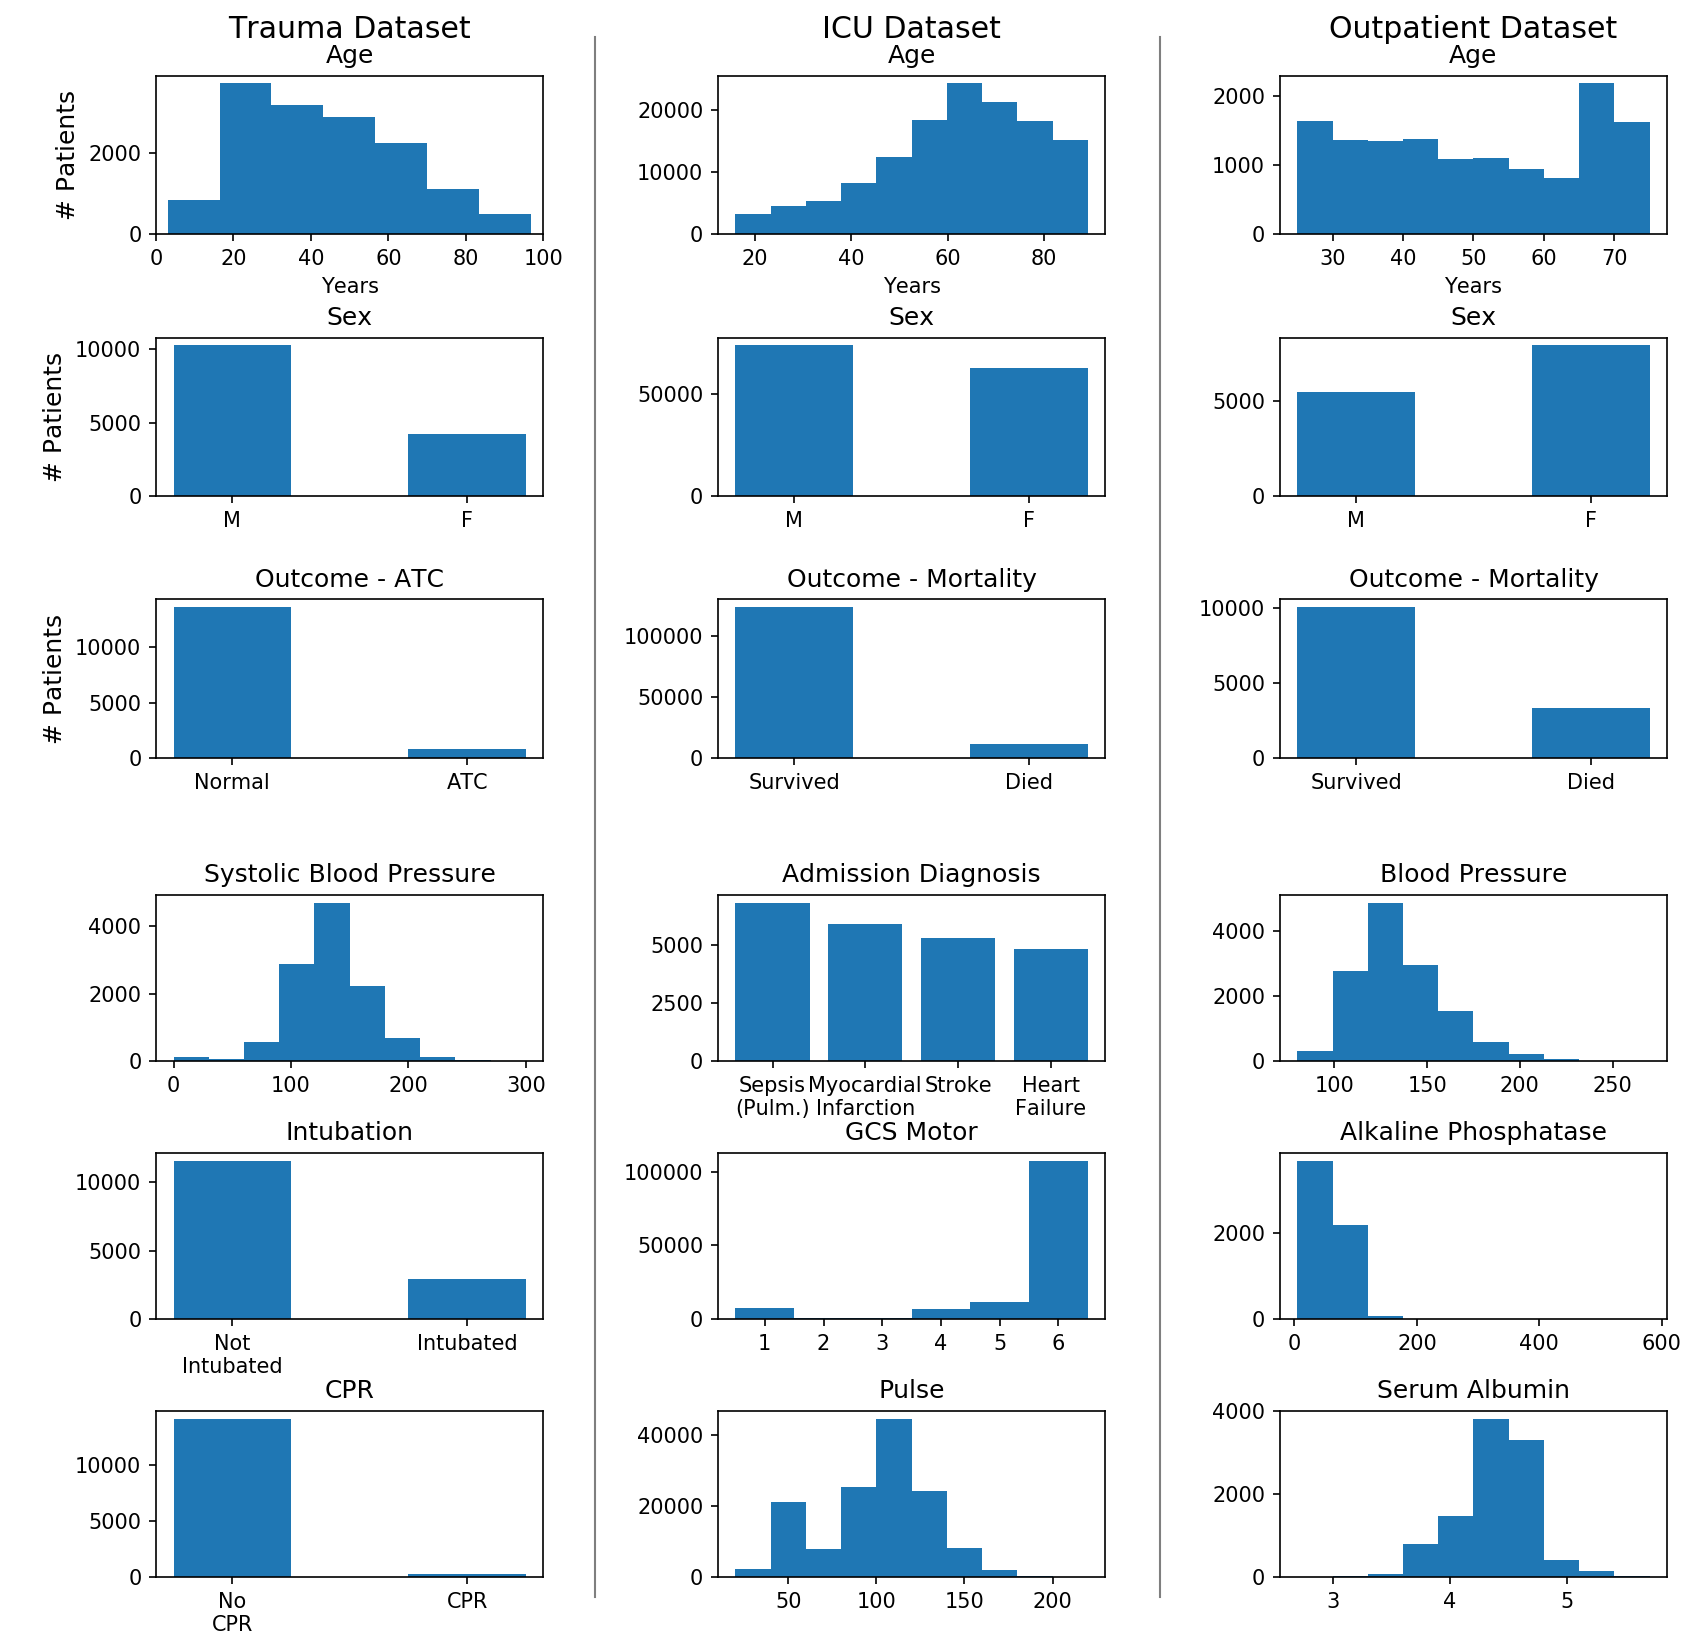

In [1034]:
from matplotlib import gridspec

axes = {}
fig = plt.figure(figsize=(13,13),dpi=150)
gs = gridspec.GridSpec(nrows=2,ncols=1,figure=fig)
gs0 = gs[0].subgridspec(3,3,hspace=0.65,wspace=0.45)
gs1 = gs[1].subgridspec(3,3,hspace=0.55,wspace=0.45)

dsets = defaultdict(dict)
rseed=1
(Xtrain,ytrain), (Xvalid,yvalid), (Xtest,ytest), costs, groups, extras = load_ed(name=config.ED_NAME,costtype=config.ED_COSTTYPE,drop_redundant=True,split_seed=rseed)
dsets['trauma']['train'] = pd.concat([Xtrain,Xvalid,Xtest]), np.hstack((ytrain,yvalid,ytest))

(Xtrain,ytrain), (Xvalid,yvalid), (Xtest,ytest), costs, groups, extras = load_eicu(split_seed=rseed)
dsets['icu']['train'] = pd.concat([Xtrain,Xvalid,Xtest]), np.hstack((ytrain,yvalid,ytest))

(Xtrain,ytrain), (Xvalid,yvalid), (Xtest,ytest), costs, groups, extras = load_outpatient(split_seed=rseed)
dsets['outpatient']['train'] = pd.concat([Xtrain,Xvalid,Xtest]), np.hstack((ytrain,yvalid,ytest))

traumacauses = {i:k for i,k in enumerate(['ABUSE', 'AIR', 'BIKE', 'BITES', 'CUT', 'DROWN', 'ELECTRO', 'ENVIRON',
       'EXPLOSION', 'FALL', 'FIRE', 'FOREIGN', 'GUN', 'MACHINE', 'MC', 'MV',
       'OTHER', 'OVEREXERTI', 'PEDESTRIAN', 'POISON', 'RAILWAY', 'SMOKE',
       'SNOW', 'STRUCK', 'SUFFOCATIO', 'TRANSPORT', 'UNSPEC', 'WATER'])}
icudiags = defaultdict(lambda : '',{'SEPSISPULM':'Sepsis\n(Pulm.)','SEPSISUTI':'Sepsis\n(UTI)','AMI':'Myocardial\nInfarction','CVASTROKE':'Stroke','CHF':'Heart\nFailure'})

def summarize(dset,feat,sps,lmbd=lambda x:x,title=None,xlabel='',xticks=None,**kwargs):
    if title is None: title = feat.capitalize()
    elif title is not False: title = title
    else: title = ''
    axes[dset,feat] = fig.add_subplot(sps)
    if feat=='outcome':
        dat = dsets[dset]['train'][1].astype(float)
    else:
        dat = dsets[dset]['train'][0][feat].astype(float)
    axes[dset,feat].hist(lmbd(dat),**kwargs)
    axes[dset,feat].set_title(title)
    if xlabel is not '': axes[dset,feat].set_xlabel(xlabel)
    if xticks is not None: 
        axes[dset,feat].set_xticks(xticks[0])
        axes[dset,feat].set_xticklabels(xticks[1])

def filtersex(v):
    return v[v>=0]
# Sex labels are flipped for trauma
def traumasex(v):
    return 1-filtersex(v)
renamecause = {'FALL': "Fall", "MV": "Motor\nVehicle", "PEDESTRIAN": "Pedes-\ntrian", 'MC': "Motor-\ncycle", 'CUT':"Cut"}
# def filtercause(v):
#     codes, counts = np.unique(v.values,return_counts=True)
#     topk_thresh = np.sort(counts)[-6]
#     topk_inds = counts>=topk_thresh
#     return v.values[np.isin(v.values,codes[topk_inds])]

# Age
summarize('trauma','age',gs0[0,0],title='Age',xlabel='Years')
summarize('icu','age',gs0[0,1],title='Age',xlabel='Years')
summarize('outpatient','age',gs0[0,2],title='Age',xlabel='Years')

# Sex
summarize('trauma','sex',gs0[1,0],lmbd=traumasex,title='Sex',bins=3,xticks=([1/6,5/6],['M','F']))
summarize('icu','gender',gs0[1,1],lmbd=filtersex,title='Sex',bins=3,xticks=([1/6,5/6],['M','F']))
summarize('outpatient','sex_isFemale',gs0[1,2],lmbd=filtersex,title='Sex',bins=3,xticks=([1/6,5/6],['M','F']))

# Outcome
summarize('trauma','outcome',gs0[2,0],title='Outcome - ATC',bins=3,xticks=([1/6,5/6],['Normal','ATC']))
summarize('icu','outcome',gs0[2,1],title='Outcome - Mortality',bins=3,xticks=([1/6,5/6],['Survived','Died']))
summarize('outpatient','outcome',gs0[2,2],title='Outcome - Mortality',lmbd=lambda x:1-x,bins=3,xticks=([1/6,5/6],['Survived','Died']))

# Trauma extras
# summarize('trauma','causecode',gs1[0,0],title='Cause of Injury',lmbd=lambda x:[])
# codes, counts = np.unique(dsets['trauma']['train'][0]['causecode'],return_counts=True)
# csort = np.argsort(counts)[::-1]
# axes['trauma','causecode'].bar(np.arange(5),counts[csort][:5])
# axes['trauma','causecode'].set_xticks(np.arange(5))
# axes['trauma','causecode'].set_xticklabels([renamecause[traumacauses[f]] for f in codes[csort][:5]])

summarize('trauma','scenefirstbloodpressure',gs1[0,0],title='Systolic Blood Pressure')
# summarize('trauma','scenefirstpulse',gs1[2,0],title='Pulse')
summarize('trauma','intub',gs1[1,0],title='Intubation',bins=3,xticks=([1/6,5/6],['Not\nIntubated','Intubated']))
# axes['trauma','intub'].set_xticks([0,1])
summarize('trauma','cpr',gs1[2,0],title='CPR',bins=3,xticks=([1/6,5/6],['No\nCPR','CPR']))
# axes['trauma','cpr'].set_xticks([0,1])

# ICU extras
# summarize('icu','admitdiagnosis',gs1[0,1],title='Admission Diagnosis',lmbd=lambda x:[])
nplot=4
axes['icu','admitdiagnosis'] = fig.add_subplot(gs1[0,1])
codes, counts = np.unique(dsets['icu']['train'][0]['admitdiagnosis'].cat.codes,return_counts=True)
csort = np.argsort(counts)[::-1]
axes['icu','admitdiagnosis'].bar(np.arange(nplot),counts[csort][:nplot])
d = dsets['icu']['train'][0]['admitdiagnosis']
axes['icu','admitdiagnosis'].set_xticks(np.arange(nplot))
axes['icu','admitdiagnosis'].set_xticklabels([icudiags[d.cat.categories[f]] for f in codes[csort][:nplot]])
axes['icu','admitdiagnosis'].set_title("Admission Diagnosis")
# summarize('icu','vent',gs1[0,1],title='Ventilated',bins=3,xticks=([1/6,5/6],['No','Yes']))
summarize('icu','motor',gs1[1,1],title='GCS Motor',bins=np.arange(7)+0.5)
axes['icu','motor'].set_xticks(np.arange(1,7))
summarize('icu','heartrate',gs1[2,1],title='Pulse')

# Outpatient extras
summarize('outpatient','systolic_blood_pressure',gs1[0,2],title='Blood Pressure')
summarize('outpatient','alkaline_phosphatase',gs1[1,2],title='Alkaline Phosphatase')
summarize('outpatient','serum_albumin',gs1[2,2],title='Serum Albumin')

axes['outpatient','age'].set_title("Age",size='large')
axes['icu','age'].set_title("Age",size='large')

axes['trauma','age'].set_title("Age",size='large')
axes['trauma','age'].set_xlim(0,100)
axes['trauma','age'].set_ylabel("\n# Patients",size='large')
axes['trauma','sex'].set_ylabel("\n# Patients",size='large')
axes['trauma','outcome'].set_ylabel("\n# Patients",size='large')
# axes['trauma','causecode'].set_ylabel("# Patients",size='large')
# axes['trauma','scenefirstbloodpressure'].set_ylabel("# Patients",size='large')
# axes['trauma','scenefirstpulse'].set_ylabel("# Patients",size='large')

for d,c,n,l in zip(['trauma','icu','outpatient'],[None,None,None],['Trauma','ICU','Outpatient'],['a)','b)','c)']):
    title = axes[d,'age'].text(0.5,1.2,f'{n} Dataset',transform=axes[d,'age'].transAxes,fontsize='x-large',horizontalalignment='center',verticalalignment='bottom')
#     ax_list = [axes[k] for k in axes if d in k]
#     Box = get_group_box(ax_list,fig,pad=0.01)
#     box_label(Box,ax_list[0],fig,l,vpad=0.01,hpad=0.01)
#     Rect = patches.Rectangle(*rectCoords(*Box),transform=fig.transFigure,zorder=-2,linewidth=2,edgecolor=c,facecolor=c,alpha=1)
#     fig.patches.append(Rect)

line = plt.Line2D((.35,.35),(.1,.9), color="k", linewidth=1,alpha=0.5)
fig.add_artist(line)
line = plt.Line2D((.64,.64),(.1,.9), color="k", linewidth=1,alpha=0.5)
fig.add_artist(line)


plt.savefig(f"{SAVE_PATH}/summary.pdf",bbox_inches='tight')

# Cost Bar Plots

In [177]:
timeresults = pd.read_csv('../data/ed-trauma/survey_time_report.csv')

In [182]:
with open(config.ED_SURVEYPATH,'r') as f:
    header = f.readline()
    cost_dict = {line.split(',')[0]: float(line.split(',')[4]) for line in f}

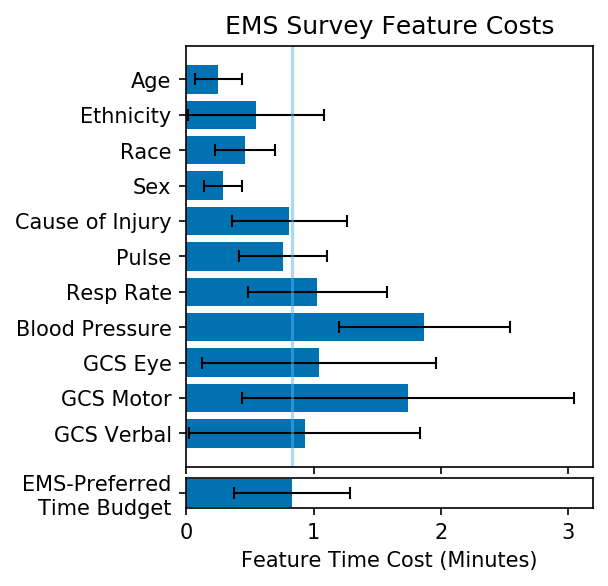

In [1461]:
fig, axarr = plt.subplots(2,1,figsize=(3.5,4),dpi=150,gridspec_kw={'height_ratios':[14,1]},sharex=True)
fig.subplots_adjust(hspace=0.05)
ax1 = axarr[0]
ax2 = axarr[1]

timeresults = pd.read_csv('../data/ed-trauma/survey_time_report.csv').set_index('DisplayName')
plot_df = timeresults.loc[[i for i in timeresults.index if i not in ['Lowest blood pressure while on scene', 'Shock index (heart rate / blood pressure)',
                                                            'GCS', 'GCS on scene', 'Highest GCS while on scene', 'Protective device (seatbelts, helmets, etc)']]]
ax1.axvline(0.83,alpha=0.5,color='#56B4E9')
ax1.barh(np.arange(plot_df.shape[0])[::-1],plot_df['Mean'], color='#0072b2')
plot_df['CI Width'] = 1.96*plot_df['Std Deviation']/np.sqrt(plot_df['Count'])
ax1.errorbar(plot_df['Mean'],np.arange(plot_df.shape[0])[::-1],xerr=plot_df['CI Width'], color='black',linestyle='',linewidth=1,capsize=3)
ax1.set_yticks(np.arange(plot_df.shape[0])[::-1])
ax1.set_yticklabels(plot_df.index)
ax1.set_yticklabels(['Age','Ethnicity','Race','Sex','Cause of Injury','Pulse','Resp Rate','Blood Pressure','GCS Eye','GCS Motor','GCS Verbal'])
ax1.set_title("EMS Survey Feature Costs")

ems_budget_mean, ems_budget_std, ems_budget_count = 0.83, 0.80, 12
ax2.barh([0],[ems_budget_mean],color='#0072b2')
ax2.errorbar([ems_budget_mean],[0],xerr=[1.96*ems_budget_std/np.sqrt(ems_budget_count)],color='black',linestyle='',linewidth=1,capsize=3)
ax2.set_xlabel("Feature Time Cost (Minutes)")
ax2.set_yticks([0])
ax2.set_yticklabels(["EMS-Preferred\nTime Budget"])
plt.savefig(f'{SAVE_PATH}/trauma_cost.pdf',bbox_inches='tight')

# Cost-Performance Curves

In [ ]:
arrays, xrs = {}, {}

Text(0, 0.5, 'ROC-AUC')

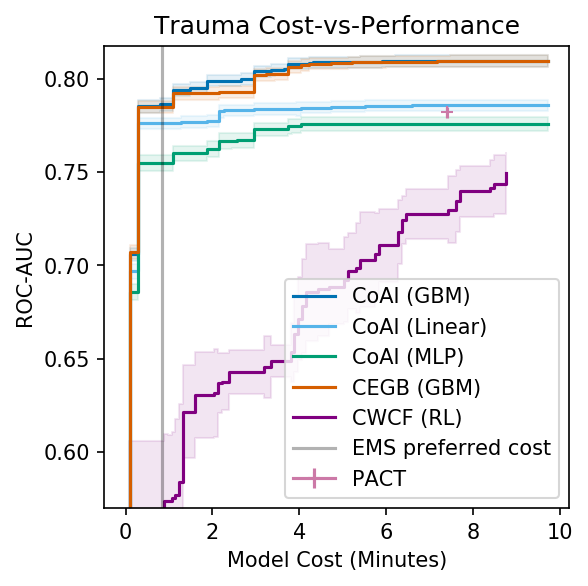

In [1421]:
# Best performance rn with IterativeImputer defaults
plt.figure(figsize=(4,4),dpi=150)
ax = plt.gca(); ax.set_ylim(0.57,0.8175)
dset = 'trauma'
base_dnames = ['gbmsage','linearsage','nnsage','cegb','cwcf']
dcolors = [cdict['darkblue'],cdict['lightblue'],cdict['green'],cdict['orange'],'purple']
fnames = ['CoAI (GBM)','CoAI (Linear)', 'CoAI (MLP)','CEGB (GBM)','CWCF (RL)']
dnames = [f'{dset}-{dname}' for dname in base_dnames]
all_valid = set([str(x) for x in range(1,101)]).intersection(*[set([(f.split('-')[2]) for f in os.listdir('rebuttal_runs') if dname in f]) for dname in dnames[:-1]])
valid_inds = np.arange(1,101)#all_valid
for dname,fname,color in zip(dnames,fnames,dcolors):
#     if dname!='trauma-gbmsage': continue
    results = []
    for i in (range(1,11) if dname=='trauma-cwcf' else valid_inds):#[0,10,12,42,45,46,48,58,5,84,8]:#range(1,54):
        try:
            stack = np.load(f'rebuttal_runs/{dname}-{i}-None.npy')
            results.append(stack)
        except FileNotFoundError: continue
    results = np.array(results)
    xr, aligned = meancostperf(results)
    xrs[dname] = xr
    arrays[dname] = aligned
    mean = np.mean(aligned,0)
    max_inds = np.array([np.argmax(mean[:i]) for i in range(1,len(mean)+1)])
    ax.step(xr,mean[max_inds],label=fname,where='post',color=color)
    std = np.std(aligned,0)
    ci_width = 1.96*std/np.sqrt(aligned.shape[0])
    ax.fill_between(xr,(mean)[max_inds]-ci_width[max_inds],(mean)[max_inds]+ci_width[max_inds],step='post',alpha=0.1,color=color)
fixed_scores = ['pact']
fixed_dnames = [f'{dset}-{dname}' for dname in fixed_scores]
for fscore in fixed_dnames:
    results = []
    for i in valid_inds:
        stack = np.load(f'rebuttal_runs/{fscore}-{i}-None.npy')
        results.append(stack)
    results = np.array(results)
    cost, score = results[:,:].mean(0).flatten()
    cstd, sstd = results[:,:].std(0).flatten()
    arrays[fscore] = results[:,:,1].reshape(-1,1)
    ci_width = 1.96*sstd/np.sqrt(results.shape[0])
    ax.errorbar([cost],[score],yerr=[ci_width],label='PACT',color=cdict['pink'],marker='+')
#     ax.scatter([cost],[score],label='PACT',color='gray',marker='x')
ax.axvline(0.83,color='black',alpha=0.3,label='EMS preferred cost')
ax.set_title('Trauma Cost-vs-Performance')
ax.legend(loc='lower right')
ax.set_xlabel("Model Cost (Minutes)")
ax.set_ylabel("ROC-AUC")
# ax.set_ylim(0.7,0.815)
# plt.savefig(f'{SAVE_PATH}/trauma_performance.pdf',bbox_inches='tight')

In [1351]:
from scipy import stats
def curve_mean_test(s1,s2,n=100):
    x1, y1, x2, y2 = *s1, *s2
    xmin = np.min(np.hstack((x1,x2)))
    xmax = np.max(np.hstack((x1,x2)))
    xr = np.linspace(xmin,xmax,n)
    y1r = np.vstack([interpolate.interp1d(x1,y,fill_value=(0.5,y[-1]),bounds_error=False)(xr) for y in y1])
    y2r = np.vstack([interpolate.interp1d(x2,y,fill_value=(0.5,y[-1]),bounds_error=False)(xr) for y in y2])
    y1m = np.mean(y1r,axis=1)
    y2m = np.mean(y2r,axis=1)
    return stats.ttest_rel(y1m,y2m)

In [1432]:
# cwcf_nruns = len(cwcf_interps[0][1])+len(cwcf_invalid)
cwcf_runs = list(range(10))
print(f"### TRAUMA p-Values ({len(cwcf_runs)} CWCF Runs) ###")
coai_test_results = {
    ('coai_gbm','coai_lin'): curve_mean_test((xrs['trauma-gbmsage'],arrays['trauma-gbmsage']),
                                             (xrs['trauma-linearsage'],arrays['trauma-linearsage'])),
    ('coai_gbm','coai_nn'): curve_mean_test((xrs['trauma-gbmsage'],arrays['trauma-gbmsage']),
                                             (xrs['trauma-nnsage'],arrays['trauma-nnsage'])),
    ('coai_gbm','cegb'): curve_mean_test((xrs['trauma-gbmsage'],arrays['trauma-gbmsage']),
                                             (xrs['trauma-cegb'],arrays['trauma-cegb'])),
    ('coai_gbm','cwcf'): curve_mean_test((xrs['trauma-gbmsage'],arrays['trauma-gbmsage'][cwcf_runs]),
                                             (xrs['trauma-cwcf'],arrays['trauma-cwcf'][cwcf_runs])),
    ('coai_gbm','coai_gbmgreedy'): curve_mean_test((xrs['trauma-gbmsage'],arrays['trauma-gbmsage']),
                                             (xrs['trauma-gbmsagegreedy'],arrays['trauma-gbmsagegreedy']))
}
trauma_result_stats = pd.DataFrame(np.zeros((len(coai_test_results),4)),columns=['Method 1', 'Method 2', 'T-statistic', 'p-value'])
for i,t in enumerate(coai_test_results):
    trauma_result_stats.iloc[i] = [*t,*coai_test_results[t]]
print(trauma_result_stats.to_latex())
trauma_result_stats

### TRAUMA p-Values (10 CWCF Runs) ###
\begin{tabular}{lllrr}
\toprule
{} &  Method 1 &        Method 2 &  T-statistic &       p-value \\
\midrule
0 &  coai\_gbm &        coai\_lin &    20.588982 &  1.477645e-37 \\
1 &  coai\_gbm &         coai\_nn &    24.706243 &  3.979652e-44 \\
2 &  coai\_gbm &            cegb &    10.209813 &  3.814833e-17 \\
3 &  coai\_gbm &            cwcf &    37.463073 &  3.412582e-11 \\
4 &  coai\_gbm &  coai\_gbmgreedy &    13.273070 &  1.049106e-23 \\
\bottomrule
\end{tabular}



,Method 1,Method 2,T-statistic,p-value
0,coai_gbm,coai_lin,20.588982,1.477645e-37
1,coai_gbm,coai_nn,24.706243,3.979652e-44
2,coai_gbm,cegb,10.209813,3.814833e-17
3,coai_gbm,cwcf,37.463073,3.412582e-11
4,coai_gbm,coai_gbmgreedy,13.273070,1.049106e-23


(0.5, 0.9)

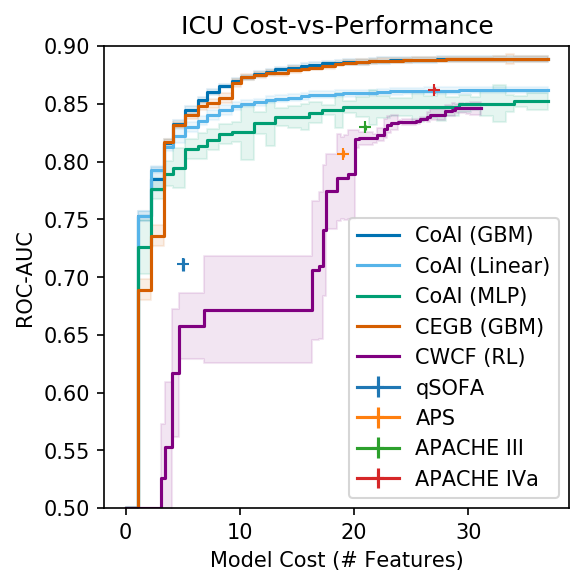

In [1434]:
# Best performance rn with IterativeImputer defaults
plt.figure(figsize=(4,4),dpi=150)
# arrays = {}
dset = 'icu'
base_dnames = ['gbmsage','linearsage','nnsage','cegb','cwcf']
dcolors = [cdict['darkblue'],cdict['lightblue'],cdict['green'],cdict['orange'],'purple']
fnames = ['CoAI (GBM)','CoAI (Linear)','CoAI (MLP)','CEGB (GBM)','CWCF (RL)']
fbases = ['qSOFA','APS','APACHE III','APACHE IVa']
dnames = [f'{dset}-{dname}' for dname in base_dnames]
all_valid = [1,2,4,5,6,7,8,9,10,11]#set([str(x) for x in range(-1,101)]).intersection(*[set([(f.split('-')[2]) for f in os.listdir('rebuttal_runs') if dname in f]) for dname in dnames[:-1]])
for dname,fname,color in zip(dnames,fnames,dcolors):
#     if dname!='icu-gbmsage': continue
    results = []
    valid_inds = ['1','2','3','4','5'] if 'cwcf' in dname else all_valid
    for i in valid_inds:#[0,10,12,42,45,46,48,58,5,84,8]:#range(1,54):
        try:
            stack = np.load(f'rebuttal_runs/{dname}-{i}-None.npy')
            results.append(stack)
        except FileNotFoundError: continue
    results = np.array(results)
    xr, aligned = meancostperf(results)
    arrays[dname] = aligned
    xrs[dname] = xr
    mean = np.mean(aligned,0)
    plt.step(xr,rmax(mean),label=fname,where='post',color=color)
    std = np.std(aligned,0)
    ci_width = 1.96*std/np.sqrt(aligned.shape[0])
    plt.fill_between(xr,rmax(mean)-ci_width,rmax(mean)+ci_width,step='post',alpha=0.1,color=color)
fixed_scores = ['qsofa','aps','apacheiii','apacheiva']
fixed_dnames = [f'{dset}-{dname}' for dname in fixed_scores]
for fscore,fbase in zip(fixed_dnames,fbases):
    results = []
    for i in range(1,11):
        stack = np.load(f'rebuttal_runs/{fscore}-{i}-None.npy')
        results.append(stack)
    results = np.array(results)
    arrays[fscore] = results[:,:,-1]
    cost, score = results[:,:].mean(0).flatten()
    cstd, sstd = results[:,:].std(0).flatten()
    ci_width = 1.96*sstd/np.sqrt(results.shape[0])
    plt.errorbar([cost],[score],yerr=[ci_width],label=fbase,marker='+')
plt.title('ICU Cost-vs-Performance')
plt.legend(loc='lower right')
plt.xlabel("Model Cost (# Features)")
plt.ylabel("ROC-AUC")
plt.ylim(0.5,0.9)
# plt.savefig(f'{SAVE_PATH}/icu_performance.pdf',bbox_inches='tight')

In [1435]:
cwcf_runs = [0,1,2,3,4]
print(f"### ICU p-Values ({len(cwcf_runs)} CWCF Runs) ###")
coai_test_results = {
    ('coai_gbm','coai_lin'): curve_mean_test((xrs['icu-gbmsage'],arrays['icu-gbmsage']),
                                             (xrs['icu-linearsage'],arrays['icu-linearsage'])),
    ('coai_gbm','coai_nn'): curve_mean_test((xrs['icu-gbmsage'],arrays['icu-gbmsage']),
                                             (xrs['icu-nnsage'],arrays['icu-nnsage'])),
    ('coai_gbm','cegb'): curve_mean_test((xrs['icu-gbmsage'],arrays['icu-gbmsage']),
                                             (xrs['icu-cegb'],arrays['icu-cegb'])),
    ('coai_gbm','cwcf'): curve_mean_test((xrs['icu-gbmsage'],arrays['icu-gbmsage'][cwcf_runs]),
                                             (xrs['icu-cwcf'],arrays['icu-cwcf'][cwcf_runs]))
}
icu_stats = pd.DataFrame(np.zeros((len(coai_test_results),4)),columns=['Method 1', 'Method 2', 'T-statistic', 'p-value'])
for i,t in enumerate(coai_test_results):
    icu_stats.iloc[i] = [*t,*coai_test_results[t]]
print(icu_stats.to_latex())
icu_stats

### ICU p-Values (5 CWCF Runs) ###
\begin{tabular}{lllrr}
\toprule
{} &  Method 1 &  Method 2 &  T-statistic &       p-value \\
\midrule
0 &  coai\_gbm &  coai\_lin &    28.203520 &  4.306756e-10 \\
1 &  coai\_gbm &   coai\_nn &     8.881477 &  9.514811e-06 \\
2 &  coai\_gbm &      cegb &    14.870843 &  1.216066e-07 \\
3 &  coai\_gbm &      cwcf &    17.459594 &  6.317949e-05 \\
\bottomrule
\end{tabular}



,Method 1,Method 2,T-statistic,p-value
0,coai_gbm,coai_lin,28.203520,4.306756e-10
1,coai_gbm,coai_nn,8.881477,9.514811e-06
2,coai_gbm,cegb,14.870843,1.216066e-07
3,coai_gbm,cwcf,17.459594,6.317949e-05


(0, 113.71729411764707)

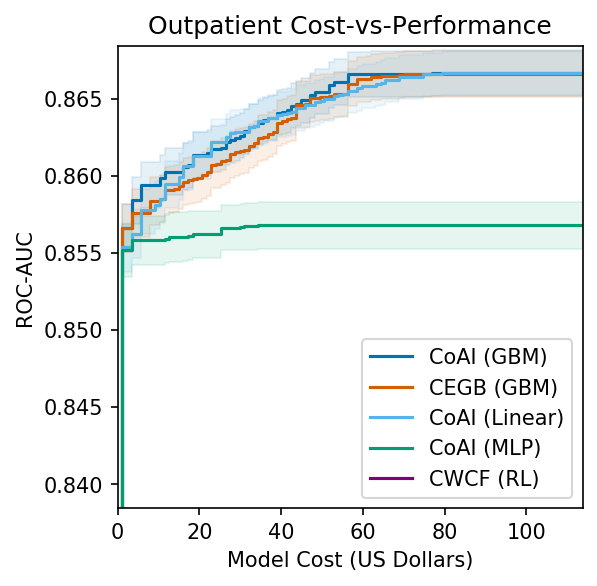

In [1410]:
# Best performance rn with IterativeImputer defaults
plt.figure(figsize=(4,4),dpi=150)
ax = plt.gca()#brokenaxes(ylims=((0.68,0.78),(0.8,0.855)), hspace=.25)
# arrays = {}
dset = 'outpatient'
base_dnames = ['gbmsage','cegbgroup','linearsage','nnsage','cwcfgroup']
dcolors = [cdict['darkblue'],cdict['orange'],cdict['lightblue'],cdict['green'],'purple']
fnames = ['CoAI (GBM)','CEGB (GBM)','CoAI (Linear)', 'CoAI (MLP)','CWCF (RL)']
dnames = [f'{dset}-{dname}' for dname in base_dnames]
all_valid = np.arange(1,101)#set([str(x) for x in range(-1,101)]).intersection(*[set([(f.split('-')[2]) for f in os.listdir('rebuttal_runs') if dname in f]) for dname in dnames[:-1]])
valid_inds = all_valid
max_costs = {}
for dname,fname,color in zip(dnames,fnames,dcolors):
    results = []
    if dname=='outpatient-cwcfgroup': valid_inds = set([str(x) for x in [1,2,4,5,6,7,9,12,13,14]])
    for i in valid_inds:#[0,10,12,42,45,46,48,58,5,84,8]:#range(1,54):
        try:
            stack = np.load(f'rebuttal_runs/{dname}-{i}-None.npy')
            results.append(stack)
        except FileNotFoundError: continue
    results = np.array(results)
    xr, aligned = meancostperf(results)
#     aligned[np.isnan(aligned)]=0.5
    max_costs[dname]=xr.max()
#     if dname=='outpatient-cwcf': aligned[:]=np.nanmax(aligned,axis=1).reshape(-1,1)
    arrays[dname] = aligned
#     assert False
    xrs[dname] = xr
    mean = np.mean(aligned,0)
    max_inds = np.array([np.argmax(mean[:i]) for i in range(1,len(mean)+1)])
    ax.step(xr,mean[max_inds],label=fname,where='post',color=color)
    std = np.std(aligned,0)
    ci_width = 1.96*std/np.sqrt(aligned.shape[0])
    ax.fill_between(xr,(mean)[max_inds]-ci_width[max_inds],(mean)[max_inds]+ci_width[max_inds],step='post',alpha=0.1,color=color)
fixed_scores = ['nodesage']
fixed_dnames = [f'{dset}-{dname}' for dname in fixed_scores]
ax.set_title('Outpatient Cost-vs-Performance')
ax.legend(loc='lower right')
ax.set_xlabel("Model Cost (US Dollars)")
ax.set_ylabel("ROC-AUC")
ax.set_ylim(0.83845,0.8684)
ax.set_xlim(0,max_costs['outpatient-gbmsage'])
# plt.savefig(f'{SAVE_PATH}/outpatient_performance.pdf',bbox_inches='tight')

In [694]:
# Median indices for gbmsage on outpatient; only used in supp
mean_aucs = [arrays[x].mean(1) for x in ['outpatient-gbmsage']]
stacked_aucs = np.vstack(mean_aucs).T
deviations = np.linalg.norm(stacked_aucs-stacked_aucs.mean(0),axis=1)
np.argsort(deviations)
print(np.array(all_valid)[np.argsort(deviations)])

[ 39  53  44  16  14  23   6   7  32  96  92  21  55  57  82 100  27  24
  84  87   1  99  28  19  71  72  29  15  60   9   4  89  54  67  78  17
  68  31  79  18  48  86  35  22  13  81  74  38  62  77  63  37  12  80
  76  97  75  46  83  47  45  61  33  95  30  25  70  51  58  49  50  69
  98   3  52  66  90  40  20  41  88  91   5  36  11   8  42  59  94  56
  10  93  65  34   2  73  64  85  43  26]


In [1411]:
# cwcf_nruns = len(cwcf_interps[0][1])+len(cwcf_invalid)
cwcf_runs = np.array([1,2,4,5,6,7,9,12,13,14])#np.array([2,4,5,7,9,12,14,16,18,19,20])-1 # filenames are 1-indexed
print(f"### OUTPATIENT p-Values ({len(cwcf_runs)} CWCF Runs) ###")
coai_test_results = {
    ('coai_gbm','coai_lin'): curve_mean_test((xrs['outpatient-gbmsage'],arrays['outpatient-gbmsage']),
                                             (xrs['outpatient-linearsage'],arrays['outpatient-linearsage'])),
    ('coai_gbm','coai_nn'): curve_mean_test((xrs['outpatient-gbmsage'],arrays['outpatient-gbmsage']),
                                             (xrs['outpatient-nnsage'],arrays['outpatient-nnsage'])),
    ('coai_gbm','cegb'): curve_mean_test((xrs['outpatient-gbmsage'],arrays['outpatient-gbmsage']),
                                             (xrs['outpatient-cegbgroup'],arrays['outpatient-cegbgroup'])),
    ('coai_gbm','cwcf'): curve_mean_test((xrs['outpatient-gbmsage'],arrays['outpatient-gbmsage'][cwcf_runs]),
                                             (xrs['outpatient-cwcfgroup'],arrays['outpatient-cwcfgroup'])),
    ('coai_gbm','coai_gbmgreedy'): curve_mean_test((xrs['outpatient-gbmsage'],arrays['outpatient-gbmsage']),
                                             (xrs['outpatient-gbmsagegreedy'],arrays['outpatient-gbmsagegreedy']))
}
outpatient_stats = pd.DataFrame(np.zeros((len(coai_test_results),4)),columns=['Method 1', 'Method 2', 'T-statistic', 'p-value'])
for i,t in enumerate(coai_test_results):
    outpatient_stats.iloc[i] = [*t,*coai_test_results[t]]
print(outpatient_stats.to_latex())
outpatient_stats

### OUTPATIENT p-Values (10 CWCF Runs) ###
\begin{tabular}{lllrr}
\toprule
{} &  Method 1 &        Method 2 &  T-statistic &       p-value \\
\midrule
0 &  coai\_gbm &        coai\_lin &     1.147185 &  2.540701e-01 \\
1 &  coai\_gbm &         coai\_nn &    23.648738 &  1.624936e-42 \\
2 &  coai\_gbm &            cegb &    10.047159 &  8.632623e-17 \\
3 &  coai\_gbm &            cwcf &     9.113839 &  7.702858e-06 \\
4 &  coai\_gbm &  coai\_gbmgreedy &    11.140171 &  3.629989e-19 \\
\bottomrule
\end{tabular}



,Method 1,Method 2,T-statistic,p-value
0,coai_gbm,coai_lin,1.147185,2.540701e-01
1,coai_gbm,coai_nn,23.648738,1.624936e-42
2,coai_gbm,cegb,10.047159,8.632623e-17
3,coai_gbm,cwcf,9.113839,7.702858e-06
4,coai_gbm,coai_gbmgreedy,11.140171,3.629989e-19


## Representative runs for trauma and ICU

Used in downstream ROC and interpretability plots

In [775]:
def spec_at_sens(yt,yp,sensitivity=0.5):
    fpr, tpr, thresholds = roc_curve(yt,yp)
    return 1-np.min(fpr[tpr>=sensitivity])

In [784]:
trauma_stats = defaultdict(list)
for i in range(1,101):
    (Xtrain,ytrain), (Xvalid,yvalid), (Xtest,ytest), costs, groups, extras = load_ed(name=config.ED_NAME,costtype=config.ED_COSTTYPE,drop_redundant=True,split_seed=i)
    coai = base.load_model(f'rebuttal_runs/trauma-gbmsage-{i}-None.coai')
    pact = base.load_model(f'rebuttal_runs/trauma-pact-{i}-None.coai')
    trauma_stats['coai_pact_cost'].append([roc_auc_score(ytest,coai.predict_proba(Xtest,max_cost=7.4)[:,1])]+[spec_at_sens(ytest,coai.predict_proba(Xtest,max_cost=7.4)[:,1],sensitivity=sens) for sens in [0.6,.73,.75]])
    trauma_stats['coai_ems_cost'].append([roc_auc_score(ytest,coai.predict_proba(Xtest,max_cost=0.83)[:,1])]+[spec_at_sens(ytest,coai.predict_proba(Xtest,max_cost=0.83)[:,1],sensitivity=sens) for sens in [0.6,.73,.75]])
    trauma_stats['pact'].append([roc_auc_score(ytest,pact.test_preds)]+[spec_at_sens(ytest,pact.test_preds,sensitivity=sens) for sens in [0.6,.73,.75]])

In [1129]:
full_array = np.hstack([trauma_stats[k] for k in ['coai_pact_cost','coai_ems_cost','pact']])

In [1131]:
# Trauma most representative run
np.argmin(np.linalg.norm(full_array-full_array.mean(0).reshape(1,-1),axis=1))+1

6

In [1118]:
icu_stats = defaultdict(list)
for i in tqdm(range(1,101)):
    (Xtrain,ytrain), (Xvalid,yvalid), (Xtest,ytest), costs, groups, extras = load_eicu(split_seed=i)
    coai = base.load_model(f'rebuttal_runs/icu-gbmsage-{i}-None.coai')
    qsofa = base.load_model(f'rebuttal_runs/icu-qsofa-{i}-None.coai')
    aps = base.load_model(f'rebuttal_runs/icu-aps-{i}-None.coai')
    apacheiii = base.load_model(f'rebuttal_runs/icu-apacheiii-{i}-None.coai')
    apacheiva = base.load_model(f'rebuttal_runs/icu-apacheiva-{i}-None.coai')
    
    qsofa_sensitivity = ((qsofa.test_preds>=2)&(ytest)).sum()/ytest.sum()
    
    icu_stats['coai_apache_cost'].append([roc_auc_score(ytest,coai.predict_proba(Xtest,max_cost=27)[:,1])]+[spec_at_sens(ytest,coai.predict_proba(Xtest,max_cost=27)[:,1],sensitivity=qsofa_sensitivity)])
    icu_stats['coai_qsofa_cost'].append([roc_auc_score(ytest,coai.predict_proba(Xtest,max_cost=3)[:,1])]+[spec_at_sens(ytest,coai.predict_proba(Xtest,max_cost=3)[:,1],sensitivity=qsofa_sensitivity)])
    icu_stats['qsofa'].append([roc_auc_score(ytest,qsofa.test_preds)]+[spec_at_sens(ytest,qsofa.test_preds,sensitivity=qsofa_sensitivity)])
    icu_stats['aps'].append([roc_auc_score(ytest,aps.test_preds)]+[spec_at_sens(ytest,aps.test_preds,sensitivity=qsofa_sensitivity)])
    icu_stats['apacheiii'].append([roc_auc_score(ytest,apacheiii.test_preds)]+[spec_at_sens(ytest,apacheiii.test_preds,sensitivity=qsofa_sensitivity)])
    icu_stats['apacheiva'].append([roc_auc_score(ytest,apacheiva.test_preds)]+[spec_at_sens(ytest,apacheiva.test_preds,sensitivity=qsofa_sensitivity)])
    icu_stats['qsofa_sensitivity'].append([qsofa_sensitivity])

  1%|          | 1/100 [00:04<08:08,  4.93s/it]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/ind

FileNotFoundError: [Errno 2] No such file or directory: 'rebuttal_runs/icu-gbmsage-11-None.coai'

In [1132]:
full_array = np.hstack([icu_stats[k] for k in ['coai_apache_cost',
'coai_qsofa_cost',
'qsofa',
'aps',
'apacheiii',
'apacheiva']])

In [1134]:
# ICU most representative run
np.argmin(np.linalg.norm(full_array-full_array.mean(0).reshape(1,-1),axis=1))+1

5

# ROC Plots

Thresholds:
* qSOFA: score >=2
* APS/APACHE III/IVa: n/a, only curves reported
* PACT: "Setting the PACT score cutoff at ≥196 maximized sensitivity and specificity at 73.1% and 73.8%, respectively"
* COAST: "a COAST score of ≥ 3 had a specificity of 96.4% with a sensitivity of 60.0%"
* ABC: >=2 gives 75% sensitivity 86% specificity 84% accuracy


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


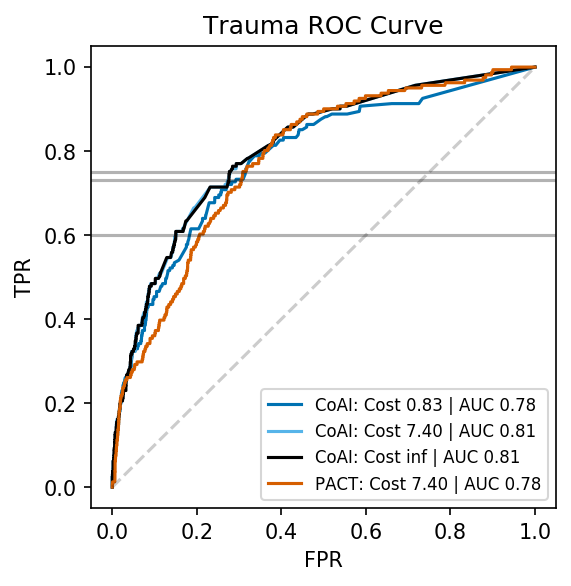

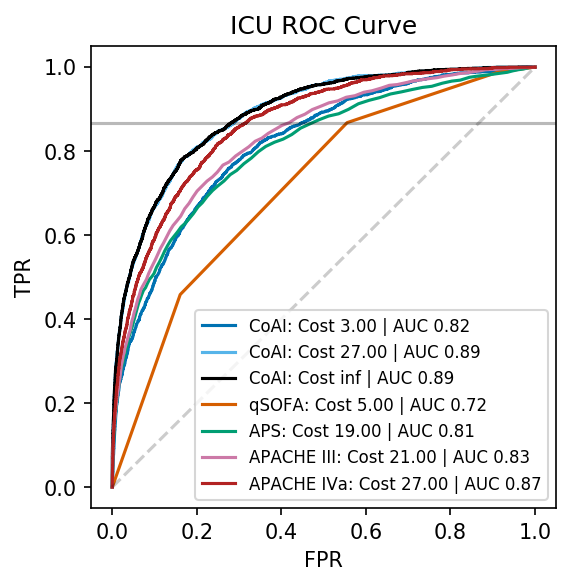

In [1135]:
# rocmodels = ['gbmsage']
trauma_run, icu_run = 7, 6 # From above
roccosts = {'trauma':[0.83,7.4,np.inf],'icu':[3,27,np.inf]}
sensitivities = {'trauma': [0.75,0.6,0.731],'icu':[icu_stats['qsofa_sensitivity'][icu_run-1]]}
baselines = {'trauma':['pact'],'icu':['qsofa','aps','apacheiii','apacheiva']}
rocmodels = ['gbmsage']

roccolors = [cdict['darkblue'],cdict['lightblue'],'black']
basecolors = [cdict['orange'],cdict['green'],cdict['pink'],'firebrick']
baserename = {'pact': "PACT", 'qsofa':'qSOFA', 'aps': 'APS', 'apacheiii': 'APACHE III', 'apacheiva': 'APACHE IVa'}
# fnames = ['CoAI (GBM)','CEGB','CoAI (Linear)']
run=7
for dset,fname in zip(['trauma'],['Trauma']):#zip(['trauma','icu'],['Trauma','ICU']):
    plt.figure(figsize=(4,4),dpi=150)
    (Xtrain,ytrain), (Xvalid,yvalid), (Xtest,ytest), costs, groups, extras = load_ed(name=config.ED_NAME,costtype=config.ED_COSTTYPE,drop_redundant=True,split_seed=run)
    for mtype in rocmodels:
        model = base.load_model(f'rebuttal_runs/{dset}-{mtype}-{run}-None.coai')
        for opcost,color in zip(roccosts[dset],roccolors):
            preds = model.predict_proba(Xtest,max_cost=opcost)[:,1]
            rocplot(ytest,preds,label=f'CoAI: Cost {opcost:.2f} | AUC {roc_auc_score(ytest,preds):.2f}',color=color)
    for mtype,color in zip(baselines[dset],basecolors):
        model = base.load_model(f'rebuttal_runs/{dset}-{mtype}-{run}-None.coai')
        preds = model.test_preds
        rocplot(ytest,preds,label=f'{baserename[mtype]}: Cost {model.model_costs.item():.2f} | AUC {roc_auc_score(ytest,preds):.2f}',color=color)
    for sens in sensitivities[dset]:
        plt.axhline(sens,color='black',alpha=0.3)
    plt.legend(fontsize=8)
    plt.plot([0,1],[0,1],color='black',alpha=0.2,linestyle='--')
    plt.title(f'{fname} ROC Curve')
#     plt.axvline(0.185,color='purple',alpha=0.5)
    plt.savefig(f'{SAVE_PATH}/{dset}_rocplot.pdf',bbox_inches='tight')
run = icu_run
for dset,fname in zip(['icu'],['ICU']):#zip(['trauma','icu'],['Trauma','ICU']):
    plt.figure(figsize=(4,4),dpi=150)
    (Xtrain,ytrain), (Xvalid,yvalid), (Xtest,ytest), costs, groups, extras = load_eicu(split_seed=run)
    for mtype in rocmodels:
        model = base.load_model(f'rebuttal_runs/{dset}-{mtype}-{run}-None.coai')
        for opcost,color in zip(roccosts[dset],roccolors):
            preds = model.predict_proba(Xtest,max_cost=opcost)[:,1]
            rocplot(ytest,preds,label=f'CoAI: Cost {opcost:.2f} | AUC {roc_auc_score(ytest,preds):.2f}',color=color)
    for mtype,color in zip(baselines[dset],basecolors):
        model = base.load_model(f'rebuttal_runs/{dset}-{mtype}-{run}-None.coai')
        preds = model.test_preds
        rocplot(ytest,preds,label=f'{baserename[mtype]}: Cost {model.model_costs.item():.2f} | AUC {roc_auc_score(ytest,preds):.2f}',color=color)
    for sens in sensitivities[dset]:
        plt.axhline(sens,color='black',alpha=0.275)
    plt.legend(fontsize=8)
    plt.plot([0,1],[0,1],color='black',alpha=0.2,linestyle='--')
    plt.title(f'{fname} ROC Curve')
#     plt.axvline(0.185,color='purple',alpha=0.5)
    plt.savefig(f'{SAVE_PATH}/{dset}_rocplot.pdf',bbox_inches='tight')

# Convergence

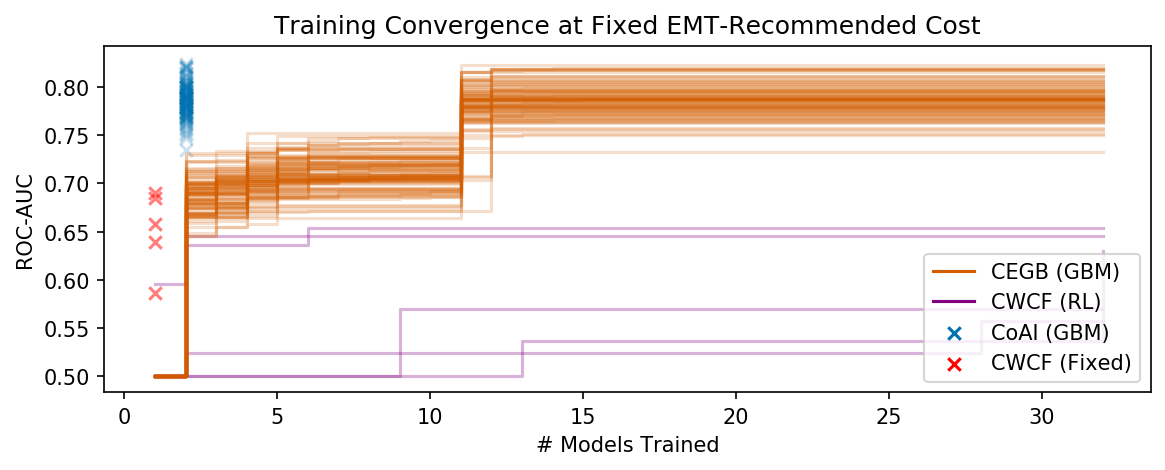

In [609]:
plt.figure(figsize=(9,3),dpi=150)
mname_mapper = {'gbmsage':'CoAI (GBM)','cegb':'CEGB (GBM)','cwcf': 'CWCF (RL)', 'cwcflagrange':'CWCF (Fixed)'}
for i in range(1,101):
    if not os.path.isfile(f'rebuttal_runs/trauma-gbmsage-{i}-None.npy'): continue
    for mname, color in [('gbmsage',cdict['darkblue']),('cegb',cdict['orange']),('cwcf','purple'),('cwcflagrange','red')]: #('gbmsage',cdict['darkblue']),
        kwargs = {'label':mname_mapper[mname]} if i==3 else {}
        if mname=='cwcf' and i not in [1,2,3,4,5]: continue
        elif mname=='cwcflagrange':
            if i not in [1,2,3,4,5]: continue
            result = np.load(f'rebuttal_runs/trauma-{mname}-{i}-complexity.npy')
            plt.scatter([1],[result[1,2]],marker='x',color=color,alpha=0.5,**kwargs)
        elif mname=='gbmsage': 
            result = np.load(f'rebuttal_runs/trauma-gbmsage-{i}-None.npy')
            plt.scatter([2],[result[7,1]],marker='x',color=color,alpha=0.2,**kwargs)
        else:
            result = np.load(f'rebuttal_runs/trauma-{mname}-{i}-complexity.npy')
            points = np.array([(i,r[2]) for i,r in enumerate(result) if r[1]<config.ED_SURVEY_BUDGET])
            bests = np.array([max(points[:,1][points[:,0]<=i],default=0.5) for i in range(32)])
            plt.step(np.arange(32)+1,bests,color=color,where='post',
                     alpha=(0.2 if mname=='cegb' else 0.3),**kwargs)
leg = plt.legend(loc='lower right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.title("Training Convergence at Fixed EMT-Recommended Cost")
plt.xlabel("# Models Trained")
plt.ylabel("ROC-AUC")
plt.savefig(f'{SAVE_PATH}/trauma_convergence.pdf',bbox_inches='tight')

# Robustness to Cost Swaps

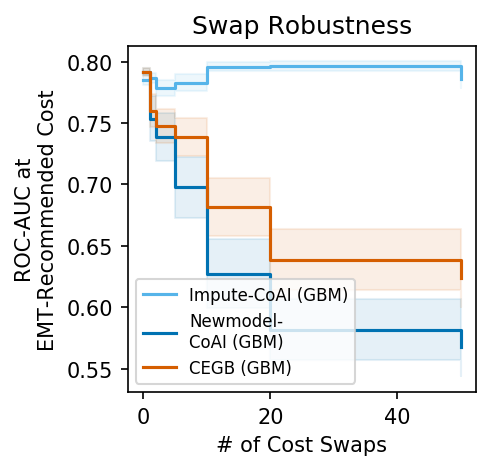

In [1436]:
# Best performance rn with IterativeImputer defaults
plt.figure(figsize=(3,3),dpi=150)
arrays = {}
xr = [0,1,2,5,10,20,50]
for dname, fname,color in zip(['trauma-imputemodel','trauma-gbmsage','trauma-cegb'],['Impute-CoAI (GBM)','Newmodel-\nCoAI (GBM)','CEGB (GBM)'],[cdict['lightblue'],cdict['darkblue'],cdict['orange']]):
    arrays[dname] = []
    for swap_size in xr:
        arrays[dname].append([])
        for split_ind in [1,2,3,4,5,6,7,8,9,10]:
            for swap_seed in range(1,11):
#                 try:
                    costs, perfs = np.load(f'rebuttal_runs/{dname}-{split_ind}-{(swap_size,swap_seed)}.npy').T
                    mcp = np.max(perfs[costs<=0.83])#np.sum(costs*perfs)/np.sum(costs)
                    arrays[dname][-1].append(mcp)
#                 except FileNotFoundError: continue
#     arrays[dname] = np.array(arrays[dname])
    mean = np.array([np.mean(x) for x in arrays[dname]])#arrays[dname].mean(1)
    plt.step(xr,mean,where='post',label=fname,color=color)
    std = np.array([np.std(x) for x in arrays[dname]])#arrays[dname].std(1)
    ci_width = 1.96*std/np.sqrt([len(x) for x in arrays[dname]])
    plt.fill_between(xr,mean-ci_width,mean+ci_width,step='post',alpha=0.1,color=color)
plt.title('Swap Robustness')
plt.legend(loc='lower left',fontsize=8)
plt.xlabel("# of Cost Swaps")
plt.ylabel("ROC-AUC at\nEMT-Recommended Cost")
# plt.ylim(0.75,0.835)
plt.savefig(f'{SAVE_PATH}/swap_robustness.pdf',bbox_inches='tight')

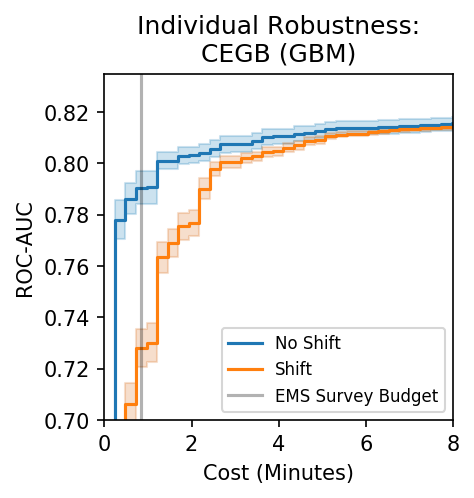

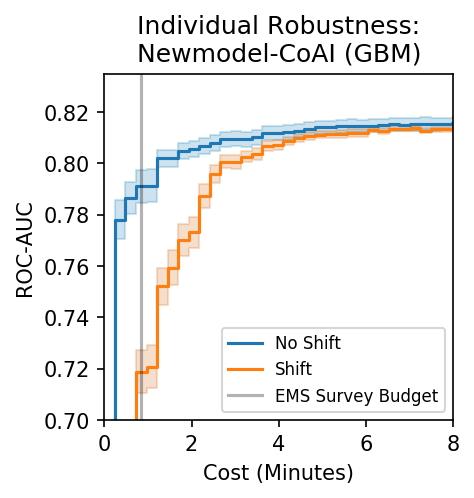

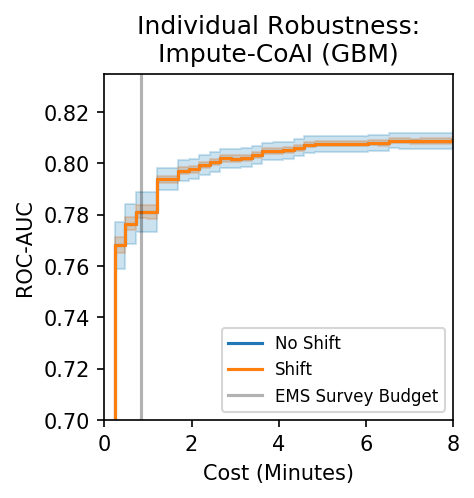

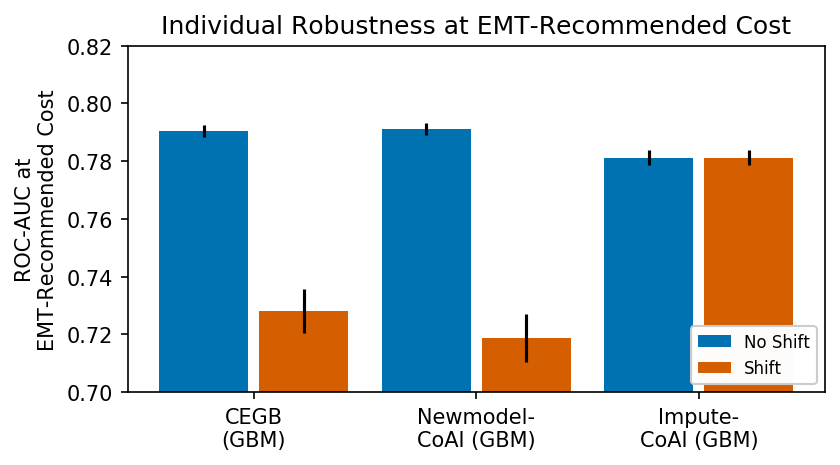

In [1437]:
# Best performance rn with IterativeImputer defaults
arrays, xrs = {}, {}
perfcost_noshift, perfcost_shift = [], []
cicost_noshift, cicost_shift = [], []
for dname, fname,color in zip(['trauma-cegb','trauma-gbmsage','trauma-imputemodel'],['CEGB (GBM)', 'Newmodel-CoAI (GBM)','Impute-CoAI (GBM)'],[cdict['orange'],cdict['darkblue'],cdict['lightblue']]):
    arrays[dname] = [[],[]]
    for swap_size in range(1,11):
        for split_ind in [1,2,3,4,5,6,7,8,9,10]:
            for swap_seed in range(1,11):
                results = np.load(f'rebuttal_runs/{dname}-{split_ind}-{(-swap_size,-swap_seed)}.npy')
#                 except FileNotFoundError: continue
                #mcp = np.max(perfs[costs<=0.83])#np.sum(costs*perfs)/np.sum(costs)
                if swap_size==swap_seed: arrays[dname][0].append(results)
                else: arrays[dname][1].append(results)
    plt.figure(figsize=(3,3),dpi=150)
    arrays[dname][0] = np.array(arrays[dname][0])
    arrays[dname][1] = np.array(arrays[dname][1])
    xr0, aligned0 = meancostperf(arrays[dname][0])
    xr1, aligned1 = meancostperf(arrays[dname][1])
    xrs[dname] = xr0,xr1
    for xr, aligned, name,color in [(xr0,aligned0,'No Shift',cdict['darkblue']),(xr1,aligned1,'Shift',cdict['orange'])]:
        mean = aligned.mean(0)
        std = aligned.std(0)
        n = aligned.shape[0]
        ci_width = 1.96*(std/np.sqrt(n))
        plt.step(xr,mean,where='post',label=name)
        plt.fill_between(xr,mean-ci_width,mean+ci_width,alpha=0.2,step='post',color=color)
    noshift_ind = np.argmax(aligned0.mean(0)[xr0<config.ED_SURVEY_BUDGET])
    shift_ind = np.argmax(aligned1.mean(0)[xr1<config.ED_SURVEY_BUDGET])
    perfcost_noshift.append(aligned0.mean(0)[xr0<config.ED_SURVEY_BUDGET][noshift_ind])
    perfcost_shift.append(aligned1.mean(0)[xr1<config.ED_SURVEY_BUDGET][shift_ind])
    cicost_noshift.append(1.96*aligned0.std(0)[xr0<config.ED_SURVEY_BUDGET][noshift_ind]/np.sqrt(n))
    cicost_shift.append(1.96*aligned1.std(0)[xr1<config.ED_SURVEY_BUDGET][shift_ind]/np.sqrt(n))
    plt.axvline(config.ED_SURVEY_BUDGET,color='black',alpha=0.3,label='EMS Survey Budget')
    plt.title(f'Individual Robustness:\n{fname}')
    plt.legend(loc='lower right',fontsize=8)
    plt.xlabel("Cost (Minutes)")
    plt.ylabel("ROC-AUC")
    plt.ylim(0.7,0.835)
    plt.xlim(0,8)
    plt.savefig(f'{SAVE_PATH}/indiv_robustness_{dname.split("-")[1]}.pdf',bbox_inches='tight')
perfcost_shift, perfcost_noshift, cicost_shift, cicost_noshift = [np.array(x) for x in [perfcost_shift, perfcost_noshift, cicost_shift, cicost_noshift]]
plt.figure(figsize=(6,3),dpi=150)
plt.title("Individual Robustness at EMT-Recommended Cost")
plt.bar(np.arange(len(perfcost_noshift)),perfcost_noshift,width=0.4,color=cdict['darkblue'],yerr=cicost_noshift,label='No Shift')
plt.bar(np.arange(len(perfcost_shift))+0.45,perfcost_shift,width=0.4,color=cdict['orange'],yerr=cicost_shift,label='Shift')
plt.xticks(np.arange(len(perfcost_shift))+0.225,['CEGB\n(GBM)', 'Newmodel-\nCoAI (GBM)','Impute-\nCoAI (GBM)'])
plt.legend(loc='lower right',fontsize=8,framealpha=0.99)
plt.ylabel("ROC-AUC at\nEMT-Recommended Cost")
plt.ylim(0.7,0.82)
plt.savefig(f'{SAVE_PATH}/indiv_robustness_summary.pdf',bbox_inches='tight')

# Model Interpretation

In [1139]:
apache_feats, apache_imps = np.load(f'eicu_importance_{icu_run}.npy',allow_pickle=True)
coaigbm = base.load_model(f'rebuttal_runs/icu-gbmsage-{icu_run}-None.coai')

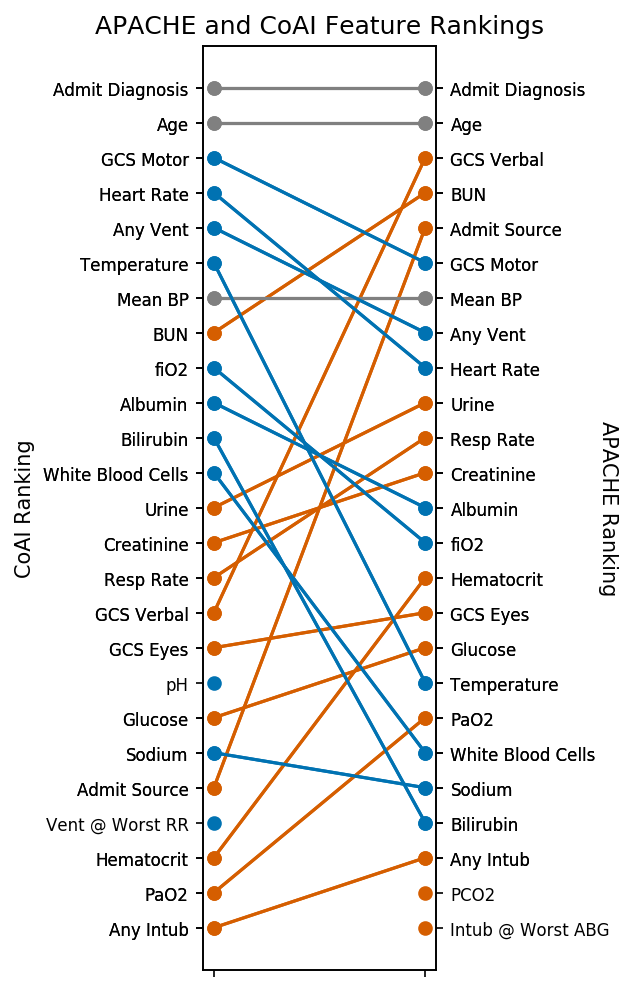

In [1146]:
# APACHE # 
fig = plt.figure(figsize=(2,8),dpi=150)
ax = fig.gca()
old_order = np.argsort(apache_imps)[::-1]
new_order = np.argsort(coaigbm.global_importances)[::-1]
plots.compare_orders(
    new_order,
    old_order,
    features=icu_newcols,ax=ax,min_per_model=25,max_per_model=24,model_names=['',''])
axt = get_twin(ax)
ax, axt = axt, ax
ax.set_yticklabels(ax.get_yticklabels(),fontsize=8)
axt.set_yticklabels(axt.get_yticklabels(),fontsize=8)
ax.set_xticklabels(['',''])
twiny = ax.set_ylabel('APACHE Ranking')
axt.set_ylabel('CoAI Ranking')
twiny.set_rotation(-90)
ax.set_title("APACHE and CoAI Feature Rankings")
plt.savefig(f'{SAVE_PATH}/interpretations_apache.pdf',bbox_inches='tight')

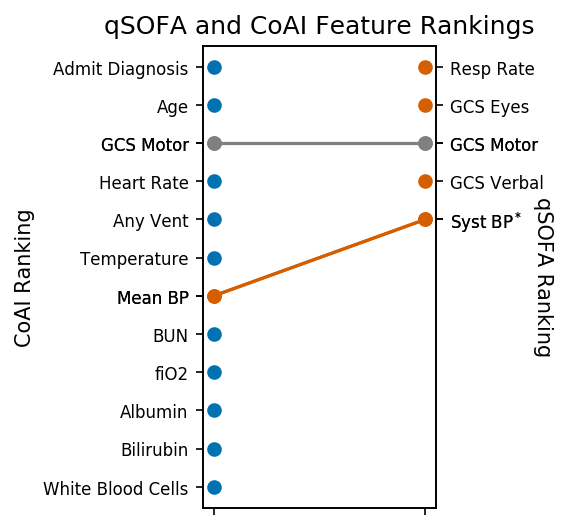

In [1147]:
# qSOFA # 
fig = plt.figure(figsize=(2,4),dpi=150)
ax = fig.gca()
# (Xtrain,ytrain), (Xvalid,yvalid), (Xtest,ytest), costs, groups, extras = LOADERS['icu']()
qsofa_imps = np.array([1 if c in ('eyes','motor','verbal','meanbp','respiratoryrate') else 0 for c in coaigbm.X.columns])
old_order = np.argsort(qsofa_imps)[::-1]
new_order = np.argsort(coaigbm.global_importances)[::-1]
plots.compare_orders(
    new_order,
    old_order,
    features=icu_newcols,ax=ax,min_per_model=[12,5],max_per_model=[12,5],model_names=['',''])
axt = get_twin(ax)
replace_yticks = axt.get_yticklabels()
for t in replace_yticks: t.set_text("Syst BP$^*$" if t.get_text()=='Mean BP' else t.get_text())
ax.set_yticklabels(ax.get_yticklabels(),fontsize=8)
axt.set_yticklabels(axt.get_yticklabels(),fontsize=8)
ax.set_xticklabels(['',''])
twiny = axt.set_ylabel('qSOFA Ranking')
ax.set_ylabel('CoAI Ranking')
twiny.set_rotation(-90)
ax.set_title("qSOFA and CoAI Feature Rankings")
plt.savefig(f'{SAVE_PATH}/interpretations_qsofa.pdf',bbox_inches='tight')

## PACT plots
May require some manual edits to correctly place dispatch/procedure features 
(these are manually added to the plot)

In [905]:
trauma_run = 7

In [906]:
DO = base.load_model(f'rebuttal_runs/trauma-gbmsage-{trauma_run}-None.coai')

In [907]:
(t_Xtrain,ytrain), (t_Xvalid,yvalid), (t_Xtest,ytest), t_costs, groups, extras = load_ed(name=config.ED_NAME,costtype=config.ED_COSTTYPE,drop_redundant=True,split_seed=trauma_run)

In [908]:
def load_if_exists(f):
    try: return np.load(f)
    except FileNotFoundError: return None
all_imps = [load_if_exists(f'rebuttal_runs/trauma-gbmsage-{trauma_run}-shaps{i}.npy') for i in range(1,len(DO.model_features))]
mat = np.zeros((DO.X.shape[1],len(DO.model_features)))
last_imps, last_finds = [], []
for i,(f_inds,imps) in enumerate(zip(DO.model_features[1:],all_imps)):
    if imps is not None:
        mat[f_inds,i+1] = imps
        last_imps, last_finds = imps, f_inds
    else:
        mat[last_finds,i+1] = last_imps

In [934]:
plt.style.use('default')
# mat = DO.global_attribs.transpose()

columns = np.array(t_Xtrain.columns)

dispatch_inds = np.where(t_costs<=config.ED_LOWCOST)[0]#[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,29,31,32,38]
non_dispatch_inds = np.array([i for i in range(len(t_costs)) if i not in list(dispatch_inds)])

dispatch_imps = np.sum(mat[dispatch_inds,:],axis=0)
newmat = np.vstack((dispatch_imps,mat[non_dispatch_inds,:]))

# sort by earliest use
earliest_inds = [np.where([i in f for f in DO.model_features])[0][0] for i in non_dispatch_inds]
non_dispatch_sort = np.argsort(earliest_inds)
newsort = np.hstack(([0],non_dispatch_sort+1))

newfeats = np.hstack((['dispatch'],columns[non_dispatch_inds][non_dispatch_sort]))
    
pact_vars_weights = {'age': 0.275, 'causecode': 0.256, 'cpr': 0.188, 'intub': 0.219, 'scenegcsmotor': 6/15*0.171, 'scenegcsverbal': 5/15*0.171, 'scenegcseye': 4/15*0.171}
pact_coefs = np.array([0 if x not in pact_vars_weights else pact_vars_weights[x] for x in t_Xtrain.columns])
new_pact_order = np.argsort(pact_coefs)[::-1]


first_uses = plots.first_feature_uses(DO)
# 'immob', 'ivp', 'bboard', 'oxy', 'ps', 
features_to_plot = ['intub', 'ccollar', 'cpr','age','sex','race','ethnicity','causecode','scenefirstpulse','scenefirstbloodpressure','scenefirstrespirationrate','scenegcsverbal','scenegcseye','scenegcsmotor']#['intub','cpr','age','causecode','scenegcsmotor','scenegcseye','scenegcsverbal','scenefirstbloodpressure','scenefirstpulse']
feature_rankings = []
for i in range(t_Xtrain.shape[1]):
    if t_Xtrain.columns[i] in features_to_plot:
        t = t_Xtrain.columns[i],first_uses[i],-pact_coefs[i]
        feature_rankings.append(t)
feature_rankings.append(('otherfeatures_15',1.1,201))
feature_rankings.append(('otherfeatures_16',90.1,201))
feature_rankings.append(('shockindex',201,-1))
for t in feature_rankings: print(t)

('age', 3, -0.275)
('causecode', 17, -0.256)
('ethnicity', 90, -0.0)
('race', 7, -0.0)
('scenefirstbloodpressure', 20, -0.0)
('scenefirstpulse', 10, -0.0)
('scenefirstrespirationrate', 45, -0.0)
('scenegcseye', 66, -0.0456)
('scenegcsmotor', 73, -0.0684)
('scenegcsverbal', 18, -0.057)
('sex', 90, -0.0)
('intub', 1, -0.219)
('ccollar', 1, -0.0)
('cpr', 1, -0.188)
('otherfeatures_15', 1.1, 201)
('otherfeatures_16', 90.1, 201)
('shockindex', 201, -1)


In [935]:
sorted_features = np.array(DO.X.columns[np.argsort(plots.first_feature_uses(DO))])
features_of_interest = features_to_plot#['cpr','intub','age','scenefirstpulse','causecode','scenefirstbloodpressure','scenegcsmotor','scenegcsverbal','sex','scenefirstrespirationrate','race','ethnicity','scenegcseye']
seen = 0
sorted_features = np.array(DO.X.columns[np.argsort(plots.first_feature_uses(DO))])
ret = []
for i in range(len(sorted_features)):
    fname = sorted_features[i]
    if fname in features_of_interest:
        ret.append(0)
        seen += 1
    else:
        ret.append(seen)
ret = np.array(ret)

In [936]:
print('ind','count','after')
extra_features = []
for i in np.unique(ret):
    print(i,np.sum(ret==i),sorted_features[np.where(ret==i)[0][0]-1])

ind count after
0 14 departuredatefromscene_day
1 13 cpr
3 3 ccollar
12 7 scenegcsmotor
13 2 ethnicity
14 7 sex


In [941]:
def varmap(x):
    try: 
        return{
    'dispatch': 'Dispatch Features',
    'intub': 'Intubated$^p$',
    'cpr': 'CPR$^p$',
    'ccollar': 'C-Collar$^p$',
    'immob': 'Other Immobilization$^p$',
    'ivp': 'IV Placement$^p$',
    'bboard': 'Backboard$^p$',
    'oxy': 'Supplemental O2$^p$',
    'ps': 'Pelvic Binder/Sheeting$^p$',
    'residencezip_kmN': 'Residence: kmN of hospital',
    'age': 'Age',
    'sex': 'Sex',
    'race': 'Race',
    'causecode': 'Injury Cause',
    'scenefirstpulse': 'Pulse',
    'ethnicity': 'Ethnicity',
    'scenefirstbloodpressure': 'BP',
    'scenefirstrespirationrate': 'Respiration Rate',
    'scenegcsverbal': 'GCS - Verbal',
    'scenegcseye': 'GCS - Eye',
    'scenegcsmotor': 'GCS - Motor',
#     'otherfeatures_1': 'Dispatch Features (1)',
#     'otherfeatures_26': 'Dispatch Features (26)',
#     'otherfeatures_6': 'Dispatch Features (6)',
    'shockindex': 'Shock Index',
}[x] 
    except KeyError: 
        return f'Dispatch/Proc ({x.split("_")[-1]})'

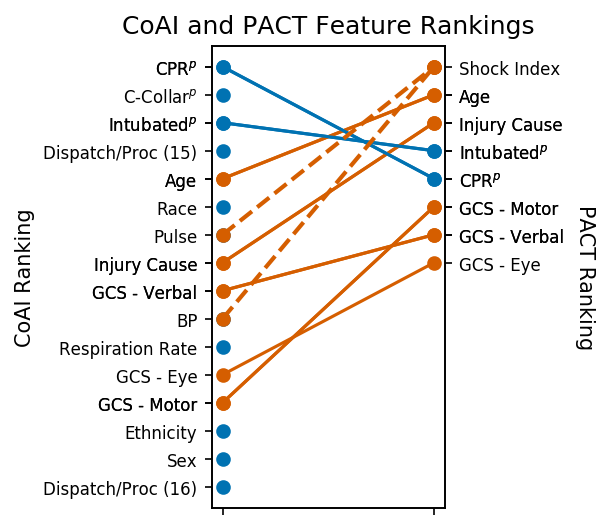

In [1035]:
# PACT #
# I think eye is actually ranked higher in CoAI than the other GCS vars
fig = plt.figure(figsize=(2,4),dpi=150)
ax = plt.gca()
ax.set_title("CoAI and PACT Feature Rankings")
plots.compare_orders(
                     np.argsort([t[1] for t in feature_rankings]),
                     np.argsort([t[2] for t in feature_rankings]),
                     features=[varmap(t[0]) for t in feature_rankings],min_per_model=[16,7], 
                    max_per_model=[15,7],
                    model_names=['',''])
axt = get_twin(ax)
ax.set_ylabel('CoAI Ranking')
twiny = axt.set_ylabel('PACT Ranking',rotation=270,labelpad=15)
# twiny.set_rotation(-90)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=8)
axt.set_yticklabels(axt.get_yticklabels(),fontsize=8)
ax.plot([0,1],[8,17],color='#D55E00',linewidth=2,linestyle='--',marker='o')
ax.plot([0,1],[11,17],color='#D55E00',linewidth=2,linestyle='--',marker='o')
xlim, ylim = ax.get_xlim(), ax.get_ylim()
plt.savefig(f'{SAVE_PATH}/interpretations_pact.pdf',bbox_inches='tight')

In [147]:
# import config, importlib
# config = importlib.reload(config)
from config import cb_cmp
pcost = 7.4
survey_max_cost=0.83

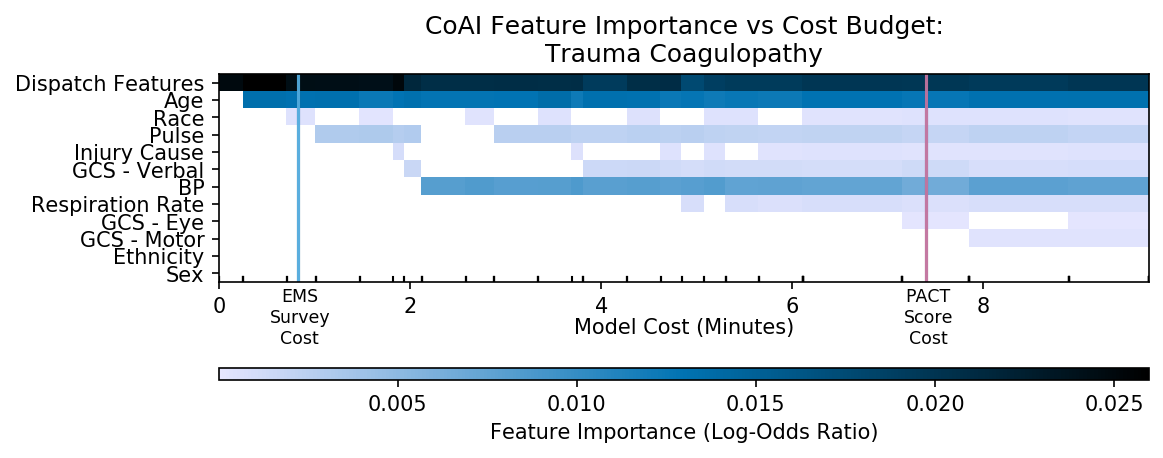

In [1072]:
# Heatmap #
fig = plt.figure(figsize=(8,3),dpi=150)
ax = plt.gca()#fig.add_subplot(gs[n-1,:])
h,w=newmat.shape[0], newmat.shape[1]
widths = DO.model_costs
heights = np.arange(h)[::-1]
X,Y = np.meshgrid(widths,heights)
im = ax.pcolormesh(X,Y,(newmat[newsort][:h,:w]),cmap=cb_cmp,vmin=0.00001)
ax.axvline(pcost,color='black',alpha=0.5)
ax.axvline(survey_max_cost,color='black',alpha=0.5)
ax.set_yticks(np.arange(-1,h)+0.5)
ax.set_ylim(0,h-1)
ax.set_yticklabels([varmap(k) for k in newfeats[::-1][-(h):]])
ax.set_xticks([0,2,4,6,8])

ax.axvline(pcost,color='#CC79A7',alpha=0.9,label='PACT Cost')
ax.axvline(survey_max_cost,color='#56B4E9',alpha=0.9,label='EMT Survey Cost')

for t in widths:
    plt.axvline(t,ymin=0,ymax=0.025,linewidth=1,color='black')

# ax.set_ylabel("Most Important Features")
ax.set_xlabel('Model Cost (Minutes)');
ax.xaxis.labelpad = 0.5#-10.5
cbar = plt.colorbar(im,orientation='horizontal',aspect=80,pad=0.25)#fig.colorbar(im, cax=axins, orientation='horizontal',aspect=60,pad=0.4)
cbar.ax.set_xlabel("Feature Importance (Log-Odds Ratio)")
ax.set_xlim(0,np.sum(t_costs))
ax.set_ylim(-1,11)
ax.set_title("CoAI Feature Importance vs Cost Budget:\nTrauma Coagulopathy")
ax.annotate('EMS\nSurvey\nCost',xy=(0.2575,0.25),xycoords='figure fraction',size='small',ha='center')
ax.annotate('PACT\nScore\nCost',xy=(0.7975,0.25),xycoords='figure fraction',size='small',ha='center')
plt.savefig(f'{SAVE_PATH}/heatmap_trauma.pdf',bbox_inches='tight')